In [7]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from dataset import Dataset
from tqdm.notebook import tqdm

In [8]:
ds = Dataset(source="../data/polybench/20-40.npz")
idxtrain, idxval = ds.partition(0.25)

In [3]:
U, S, V = np.linalg.svd(ds.matrix)

def reconstruct(d=16):
    return U[:, :d] @ np.diag(S[:d]) @ V[:d]

def err(pred):
    return np.sqrt(np.mean(np.square(np.log(pred) - np.log(ds.matrix))))

print(err(reconstruct(d=1)))

0.2792031938480987


In [16]:
def sample(split, batch=64):
    choices = np.random.choice(np.arange(split.shape[0]), size=batch)
    return split[choices]

In [14]:
def log_sq_loss(pred, true):
    return torch.mean(torch.square(pred - torch.log(true)))


class NMF:

    def __init__(self, d=32, scale=1.0, dims=(10, 10), log=False):
        x1 = np.random.uniform(size=(dims[0], d)) * np.sqrt(scale / d)
        x2 = np.random.uniform(size=(dims[1], d)) * np.sqrt(scale / d)
        self.x1 = torch.tensor(x1.astype(np.float32), requires_grad = True)
        self.x2 = torch.tensor(x2.astype(np.float32), requires_grad = True)
        self.log = log

        self.weights = [self.x1, self.x2]
    
    def forward(self, idx):
        res = torch.sum(self.x1[idx[:, 0]] * self.x2[idx[:, 1]], axis=1)
        if not self.log:
            return torch.log(res)
        else:
            return res

    def project(self):
        with torch.no_grad():
            self.x1[self.x1 < 0] = 0.
            self.x2[self.x2 < 0] = 0.

In [10]:
class MFNN:

    def __init__(self, d=32, scale=1.0, dims=(10, 10), log=False):
        x1 = np.random.uniform(size=(dims[0], d)) * np.sqrt(scale / d)
        x2 = np.random.uniform(size=(dims[1], d)) * np.sqrt(scale / d)
        self.x1 = torch.tensor(x1.astype(np.float32), requires_grad = True)
        self.x2 = torch.tensor(x2.astype(np.float32), requires_grad = True)

        self.fc = [
            torch.nn.Linear(d * 2, 64),
            torch.nn.Linear(64, 32),
        ]
        self.out = torch.nn.Linear(32, 1)

        self.weights = (
            [self.x1, self.x2, self.out.weight] + [f.weight for f in self.fc])
    
    def forward(self, idx):
        
        x = torch.concat(
            [self.x1[idx[:, 0]], self.x2[idx[:, 1]]], axis=1)
        for fc in self.fc:
            x = fc(x)
            x = torch.sigmoid(x)
        return self.out(x).reshape(-1)

    def project(self):
        pass

In [11]:
class NMFPlus:

    def __init__(self, features, d=32, scale=1.0, dims=(10, 10)):

        # x1 = np.random.uniform(size=(dims[0], d)) * np.sqrt(scale / d)
        x2 = np.random.uniform(size=(dims[1], d)) * np.sqrt(scale / d)
        # self.x1 = torch.tensor(x1.astype(np.float32), requires_grad=True)
        self.x2 = torch.tensor(x2.astype(np.float32), requires_grad=True)

        self.features = torch.tensor(features)

        self.fc = [
            torch.nn.Linear(d + features.shape[1], 64),
            torch.nn.Linear(64, 32),
        ]
        self.out = torch.nn.Linear(32, 1)

        self.weights = (
            [self.x2, self.out.weight] + [f.weight for f in self.fc])

    def forward(self, idx):

        # x = torch.concat(
        #     [self.x1[idx[:, 0]], self.x2[idx[:, 1]], self.features[idx[:, 0]]],
        #     axis=1)
        x = torch.concat(
            [self.x2[idx[:, 1]], self.features[idx[:, 0]]], axis=1)
        for fc in self.fc:
            x = fc(x)
            x = torch.sigmoid(x)
        return self.out(x).reshape(-1)
    
    def project(self):
        pass


In [12]:
def train(model, idxtrain, idxval, X, batch=64, steps=1000, initlr=0.001):

    train_loss = []
    val_loss = []

    opt = torch.optim.Adam(model.weights, lr=initlr)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
    for _ in tqdm(range(100)):
        epoch_losses = []
        for _ in range(steps):

            opt.zero_grad()

            idx = sample(idxtrain, batch)
            pred = model.forward(idx)
            loss = log_sq_loss(pred, X[idx[:, 0], idx[:, 1]])

            loss.backward()

            opt.step()
            model.project()

            epoch_losses.append(loss.detach().numpy())

        train_loss.append(np.mean(epoch_losses))
        sch.step(train_loss[-1])
        
        pred = model.forward(idxval)
        loss = log_sq_loss(pred, X[idxval[:, 0], idxval[:, 1]])
        val_loss.append(loss.detach().numpy())

    return np.array(train_loss), np.array(val_loss)


In [17]:
model = NMF(d=1, scale=np.mean(ds.matrix), dims=ds.matrix.shape)

train_loss, val_loss = train(
    model, idxtrain, idxval, torch.tensor(ds.matrix),
    batch=64, steps=1000, initlr=0.002)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'D=32: val_best=0.224')

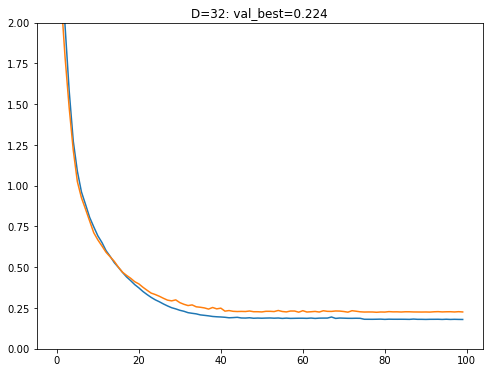

In [18]:

fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot(np.sqrt(train_loss))
axs.plot(np.sqrt(val_loss))
axs.set_ylim(0, 2)
axs.set_title("D={}: val_best={:.3f}".format(32, np.nanmin(np.sqrt(val_loss))))

In [19]:
model = MFNN(d=8, scale=np.mean(ds.matrix), dims=ds.matrix.shape)

train_loss, val_loss = train(
    model, idxtrain, idxval, torch.tensor(ds.matrix),
    batch=64, steps=100, initlr=0.001)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'val_best=0.237')

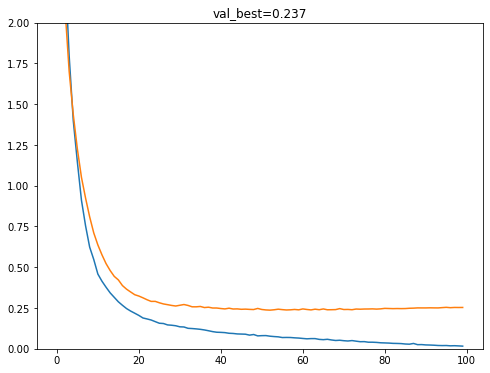

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot(np.sqrt(train_loss))
axs.plot(np.sqrt(val_loss))
axs.set_ylim(0, 2)
axs.set_title("val_best={:.3f}".format(np.nanmin(np.sqrt(val_loss))))

In [217]:
from sklearn.decomposition import PCA

ft = PCA().fit_transform(np.log(ds.opcodes + 1))[:, :8]
model = NMFPlus(ft, d=8, scale=np.mean(ds.matrix), dims=ds.matrix.shape)

train_loss, val_loss = train(
    model, idxtrain, idxval, torch.tensor(ds.matrix), batch=64, steps=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'D=32: val_best=0.255')

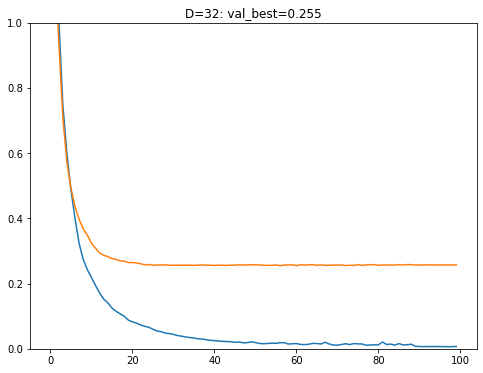

In [218]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot(np.sqrt(train_loss))
axs.plot(np.sqrt(val_loss))
axs.set_ylim(0, 1)
axs.set_title("D={}: val_best={:.3f}".format(32, np.min(np.sqrt(val_loss))))
